# Plain Autoencoder

In [ ]:
import torch
import torch.nn as nn
from sklearn import datasets
import numpy as np
from torch.utils.data import DataLoader
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from generative_baselines import GMM, sample_from_GMM
from sklearn.ensemble import RandomForestClassifier as RFC
from torch.nn import MSELoss
from sklearn.mixture import GaussianMixture
from sklearn.datasets import load_digits

MSE = MSELoss()

In [56]:
# Helper functions
def get_dimensions(layers:int, input_size:int, hidden_size:int, bottleneck_size:int) -> np.array:
    """
    Get an np.array of layer dimensions to construct a set of linear layers. 
    Start from input_size, increase linearly in dimension up to hidden_size, then back down to bottleneck_size
    (ie encoder), then proceed symmetrically for the decoder.
    """
    # Obtain encoder layer dimensions 
    num_increasing_layers = np.floor(layers/2).astype(int)
    num_decreasing_layers = layers - num_increasing_layers
    increasing_layer_dims = np.linspace(input_size, hidden_size, num_increasing_layers, dtype = int)
    decreasing_layer_dims = np.linspace(hidden_size, bottleneck_size, num_decreasing_layers, dtype = int)
    encoder_layer_dims = np.concatenate([increasing_layer_dims,decreasing_layer_dims])

    # obtain decoder layer dims symmetric to encoder and concatenate together for all layer dims
    decoder_layer_dims = encoder_layer_dims[::-1] # Reverse and then skip first element (don't duplicate bottleneck)

    return encoder_layer_dims, decoder_layer_dims

def create_mlp_from_dim_array(dims: np.array) -> nn.Module:
    """
    Given an array of dimensions, create an mlp that has linear layers followed by ReLus except in the last step
    """
    layers = []
    for l in range(len(dims) - 1):
            # Add a Linear layer with the given input and output size
            layers.append(nn.Linear(dims[l], dims[l + 1]))
            # Add a ReLU activation function after each linear layer except after bottleneck and end
            if l < len(dims) - 2:
                layers.append(nn.ReLU())

    model = nn.Sequential(*layers)

    return model

class AutoEncoder(nn.Module):
    def __init__(self, input_size, bottleneck_size, hidden_size, layers):
        """
        Pass hidden size either as an int (in which case ramp linearly from input size to
        hidden size and back down to bottleneck size) or as a list of dimensions for each layer.
        """
        super().__init__()

        # Store architecture parameters
        self.input_size = input_size
        self.bottleneck_size = bottleneck_size
        self.hidden_size = hidden_size
        self.layers = layers

        # Obtain layer dimensions if an int is passed for hidden_size
        if isinstance(hidden_size, int):
            encoder_dims, decoder_dims = get_dimensions(layers, input_size, hidden_size, bottleneck_size)
        else:
            encoder_dims = np.array(hidden_size)
            decoder_dims = np.array(hidden_size[::-1])


        # Make model of alternating linear layers and ReLu activations
        self.encoder = create_mlp_from_dim_array(encoder_dims)
        self.decoder = create_mlp_from_dim_array(decoder_dims)

    def forward(self, x):
        # Pass standardised data through model
        code = self.encoder(x)
        x_hat = self.decoder(code)

        return code, x_hat

def train_epoch(model, train_loader, epoch_index, tb_writer, optimiser, loss_fn, mmd_loss = False):
    running_loss = 0.
    last_loss = 0.
    metrics = {'MAE': 0} 

    for i, x_batch in enumerate(train_loader):
        # Zero out gradients
        optimiser.zero_grad()

        # Make predictions (discard codes)
        codes, x_hat = model(x_batch)

        # Get loss, metrics, and gradients
        if not mmd_loss:
            loss = loss_fn(x_hat, x_batch)
        else:
            loss = loss_fn(x_hat, codes, x_batch)
        loss.backward()
        metrics['MAE'] += nn.functional.l1_loss(x_hat, x_batch).detach() 

        # Update
        optimiser.step()

        # Write to tensorboard
        running_loss += loss.item()
        if i % 100 == 99:
            last_loss = running_loss / 100 # loss per batch
            #print(f'  batch {i+1} training loss: {last_loss}')
            total_batches = epoch_index * len(train_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, total_batches)
            running_loss = 0.

    metrics['MAE'] = metrics['MAE']/len(train_loader) # Divide by number of batches to get average MAE
    #print(f'  epoch {epoch_index+1} training MAE (batch averaged): {metrics["MAE"]}')

    tb_writer.flush() # Write batch losses for this epoch to disk
    return last_loss

def get_train_val_split(x_train, batch_size, seed = 11121):
    # Make a training/validation split: shuffle and then split 80/20
    if seed:
        torch.manual_seed(seed)

    shuffled_inds = torch.randperm(x_train.shape[0])
    x_train = x_train[shuffled_inds]
    cut_index = np.floor(0.8*x_train.shape[0]).astype(int)
    x_train, x_val = x_train[:cut_index], x_train[cut_index:]

    train_loader = DataLoader(x_train, batch_size = batch_size)
    val_loader = DataLoader(x_val, batch_size=4)

    return train_loader, val_loader

def get_val_loss(model, val_loader, loss_fn, mmd_loss = False):
    model.eval()
    val_loss = 0
    for x_batch in val_loader:
        code, x_hat = model(x_batch)

        if not mmd_loss:
            loss = loss_fn(x_hat, x_batch)
        else:
            loss = loss_fn(x_hat, code, x_batch)

        val_loss+=loss

    # Divide to get loss averaged over batches
    val_loss = val_loss/len(val_loader)

    return val_loss

def train_model(model, n_epoch, loss_fn, x_train, lr, mmd_loss = False, batch_size = 4, seed = 11121):
    # Get extra necessary objects
    tb_writer = SummaryWriter()
    optimiser = torch.optim.Adam(params=model.parameters(), lr=lr)

    # Define counter for early stopping to avoid overfitting/computation inefficiency
    early_stop_counter = 0
    early_stop_counter_max = 200 # Stop if no improvement in val loss after this many epochs

    # Make a training/validation split: shuffle and then split
    train_loader, val_loader = get_train_val_split(x_train, batch_size, seed)

    # Train. Terminate early based on validation loss.
    best_val_loss = float('inf')

    for epoch_index in range(n_epoch):
        #print('EPOCH {}:'.format(epoch_index + 1))

        model.train()
        _ = train_epoch(model, train_loader, epoch_index, tb_writer, optimiser, loss_fn, mmd_loss)

        # Get validation loss
        val_loss = get_val_loss(model, val_loader, loss_fn, mmd_loss)

        #print(f'  validation batch loss: {val_loss}')
        total_batches = epoch_index * len(train_loader)
        tb_writer.add_scalar('Loss/validation', val_loss, total_batches)

        # If best loss is beat, then keep going. Else increment counter. Stop if counter gets too high
        if val_loss < best_val_loss:
            early_stop_counter = 0 # If best loss fals
            best_val_loss = val_loss
        else:
            early_stop_counter +=1
            if early_stop_counter == early_stop_counter_max:
                print(f'Early stopping after {epoch_index + 1} epochs')
                break

## Train plain autoencoder

In [ ]:
# Hparams
## Architecture hparams
input_size = 2 # Data dimensionaliy
bottleneck_size = 2
hidden_size = 2 # Maximum dimension of hidden layers
layers = 3 # number of layers in the encoder

## Training hparams
n_train = 1000
lr = 0.001
n_epoch = 1000
seed = 11121

# Get data
x_train = datasets.make_moons(n_samples = n_train, noise = 0.1)[0]

## convert data to tensor and standardise
x_train = torch.from_numpy(x_train).float()
mean, sd = x_train.mean(dim=0), x_train.std(dim=0)
x_standardised = (x_train-mean)/sd

# Get model
if seed is not None:
    torch.manual_seed(seed)

autoencoder = AutoEncoder(input_size, bottleneck_size, hidden_size, layers)

# Train model
loss_fn = nn.MSELoss()
train_model(autoencoder, n_epoch, loss_fn, x_standardised, lr, mmd_loss = False)

# mmd AE

In [33]:
# Helper functions
def squared_exponential_kernel(a, b, h = 1):
    result = torch.empty((a.shape[0], b.shape[0]))

    for i in range(a.shape[0]):
        for j in range(b.shape[0]):
            result[i, j] = torch.exp(-torch.sum(torch.pow(a[i]-b[j], 2))/h)
    return result

def inverse_multiquad_kernel(a, b, h = 1):
    result = torch.empty((a.shape[0], b.shape[0]))
    for i in range(a.shape[0]):
        for j in range(b.shape[0]):
            result[i, j] = torch.pow((torch.sum(torch.pow(a[i]-b[j], 2))/h+1), -1)  
    return result

def MMD2(prediction_set, true_set, bandwidth_start, num_bandwidths):
    bandwidths = [bandwidth_start*2**i for i in range(num_bandwidths)]
    # Define kernel functions to use: Sum of squared exponential kernels or 
    # sum of inverse multiquadratic kernels.
    kernels = [squared_exponential_kernel, inverse_multiquad_kernel]

    # Convert to np array if needed
    if isinstance(prediction_set, list):
        prediction_set = np.array(prediction_set)
    if isinstance(true_set, list):
        true_set = np.array(true_set)

    # Find number of predictions and true samples
    N = prediction_set.shape[0]
    M = true_set.shape[0]

    # Calculate squared mean discrepancy per kernel and return maximum
    squared_mean_discrepancies = torch.zeros(len(kernels))
    for i, kernel_unbandwidthed in enumerate(kernels):
        kernel_squared_mean_disrepancy = 0 # will be the sum of all the bandwidthed kernels)\
        for bandwidth in bandwidths:
            kernel = lambda a, b: kernel_unbandwidthed(a, b, bandwidth)
            bandwidth_squared_mean_discrepancy = \
                kernel(true_set, true_set).sum() - kernel(true_set, true_set).diag().sum()/(N*(N-1)) + \
                kernel(prediction_set, prediction_set).sum()-kernel(prediction_set, prediction_set).diag().sum()/(M*(M-1)) - \
                2*kernel(prediction_set, true_set).sum()/(N*M)
            kernel_squared_mean_disrepancy += bandwidth_squared_mean_discrepancy
        
        squared_mean_discrepancies[i] = kernel_squared_mean_disrepancy
    
    mmd2 = squared_mean_discrepancies.max()

    return mmd2

def mmd2_mse_loss(x_hat, codes, x_batch, bandwidth_start, num_bandwidths, mmd_weight):
    # Get MSE loss
    mse = nn.functional.mse_loss(x_hat, x_batch)

    # Get MMD2 loss between some random normal samples and the codes.
    true_set = torch.randn(codes.shape)
    mmd2 = MMD2(codes, true_set, bandwidth_start, num_bandwidths)
    
    return mse + mmd_weight*mmd2

def train_mmd_autoencoder(autoencoder, n_epoch, loss_fn, x_standardised, lr):
    return train_model(autoencoder, n_epoch, loss_fn, x_standardised, lr, mmd_loss = True)


## Train mmd autoencoder

In [34]:
# Hparams
## Architecture hparams
input_size = 2 # Data dimensionaliy
bottleneck_size = 2
hidden_size = 2 # Maximum dimension of hidden layers
layers = 3 # number of layers in the encoder

## Training hparams
n_train = 1000
lr = 0.001
n_epoch = 50
seed = 11121
mmd_weight = 1
bandwidth_start = 0.5
num_bandwidths = 5

# Get data
x_train = datasets.make_moons(n_samples = n_train, noise = 0.1)[0]

## convert data to tensor and standardise
x_train = torch.from_numpy(x_train).float()
mean, sd = x_train.mean(dim=0), x_train.std(dim=0)
x_standardised = (x_train-mean)/sd

# Get model
if seed is not None:
    torch.manual_seed(seed)

mmd_autoencoder = AutoEncoder(input_size, bottleneck_size, hidden_size, layers)

# Train model
loss_fn = partial(mmd2_mse_loss, bandwidth_start = bandwidth_start, num_bandwidths = num_bandwidths, mmd_weight = mmd_weight)
train_mmd_autoencoder(mmd_autoencoder, n_epoch, loss_fn, x_standardised, lr)
mmd_autoencoder.eval()

KeyboardInterrupt: 

## Generate synthetic data

In [35]:
def gen_synth_data(autoencoder, n_synth, mean, sd):
    autoencoder.eval()
    codes = torch.randn(n_synth, autoencoder.bottleneck_size)
    synth_data = autoencoder.decoder(codes)

    # Undo normalisation
    synth_data = synth_data*sd + mean
    return synth_data

# Evaluation

In [ ]:
def evaluate_space(
    train_data, 
    test_data, 
    n_epoch, 
    loss_fn, 
    lr, 
    hidden_size_space = np.arange(5, 7, 1, dtype = np.int32), 
    layers_space = np.arange(5, 7, 1, dtype=np.int32), 
    input_size: int = 2, 
    bottleneck_size: int = 1, 
    mmd_loss: bool = False):
    """
    Considers all possible combinations of hyperparameters passed by a user. This is essentially a special case of
    the function evaluate_selection with more compact plotting.
    """
    # create figure for example plots
    fig, axs = plt.subplots(hidden_size_space.shape[0], layers_space.shape[0], figsize = (12, 8))
    # create figure for test set reconstruction error
    error_fig, error_ax = plt.subplots(1, 1, figsize = (8, 6))
    # initialize empty array for error values
    errors = np.empty((hidden_size_space.shape[0], layers_space.shape[0]))

    # loop over hyperparameter configs
    for i, hidden_size in enumerate(hidden_size_space):
        for j, layers in enumerate(layers_space):
            print(f"Running evaluation for hidden size {hidden_size} and {layers} layers.")
            # init autoencoder
            AE = AutoEncoder(input_size, bottleneck_size, int(hidden_size), int(layers))
            # train autoencoder
            if not mmd_loss:
                train_model(AE, n_epoch, loss_fn, train_data, lr, mmd_loss = False)
            else:
                train_mmd_autoencoder(AE, n_epoch, loss_fn, train_data, lr)
            # reconstruct test set
            outputs = AE.forward(test_data)[1].detach().cpu()
            # calculate errors
            errors[i, j] = MSE(outputs, test_data)
            if input_size == 2:
                # plot examples
                axs[i, j].scatter(test_data[:, 0], test_data[:, 1], color = "red", marker = "x", label = "test data")
                axs[i, j].scatter(outputs[:, 0], outputs[:, 1], color = "green", marker = "x", label = "reconstructions")
                for k in range(test_data.shape[0]):
                    axs[i, j].annotate("", xy = outputs[k], xytext = test_data[k], arrowprops = dict(arrowstyle = "->", lw = 2, color = "red"))
                axs[i, j].set_xlabel("x")
                axs[i, j].set_ylabel("y")
                axs[i, j].legend()
                axs[i, j].set_title(f"Hidden size {hidden_size} and {layers} layers")
            else:
                axs[i, j].imshow(np.concatenate((outputs[0], outputs[1], outputs[2]), axis = 1))
    fig.suptitle(f"Example data for bottleneck size {bottleneck_size}")
    fig.show()

    # plot errors
    for i, hidden_size in enumerate(hidden_size_space):
        error_ax.plot(layers_space, errors[i, :], marker = "x", label = f"Hidden size {hidden_size}")
    error_ax.set_xlabel("Number of layers")
    error_ax.set_ylabel("Reconstruction error")
    error_ax.legend()
    error_ax.set_title(f"Reconstruction errors for bottleneck size {bottleneck_size}")
    error_fig.show()

def evaluate_selection(
    selected_hps, 
    training_data_sets, 
    test_data, 
    n_epoch, 
    loss_fn, 
    lr, 
    input_size = 2, 
    bottleneck_size = 1):
    """
    Considers a selection of hyperparameters explicitly passed by the user.
    """
    colors = ["green", "purple", "orange", "black"]
    # create figure for example plots
    fig, axs = plt.subplots(len(selected_hps))
    # create figure for test set reconstruction error
    error_fig, error_ax = plt.subplots(1, 1, figsize = (8, 6))
    # initialize empty array for error values
    errors = np.empty((len(selected_hps), len(training_data_sets)))

    # loop over hyperparameter configs
    for i, (hidden_size, layers) in enumerate(selected_hps):
        # init autoencoder
        AE = AutoEncoder(input_size, bottleneck_size, int(hidden_size), int(layers))
        axs[i].scatter(test_data[:, 0], test_data[:, 1], color = "red", marker = "x", label = "test data")
        for j, train_data in enumerate(training_data_sets):
            # train autoencoder
            train_model(AE, n_epoch, loss_fn, train_data, lr, mmd_loss = False)
            # reconstruct test set
            outputs = AE.forward(test_data)[1].detach().cpu()
            # calculate errors
            errors[i, j] = MSE(outputs, test_data)
            # plot examples
            if input_size == 2:
                axs[i].scatter(outputs[:, 0], outputs[:, 1], color = colors[j], marker = "x", label = f"reconstructions {j}")
                for k in range(test_data.shape[0]):
                    axs[i].annotate("", xy = outputs[k], xytext = test_data[k], arrowprops = dict(arrowstyle = "->", lw = 2, color = colors[j]))
                axs[i].set_xlabel("x")
                axs[i].set_ylabel("y")
                axs[i].legend()
                axs[i].set_title(f"Hidden size {hidden_size} and {layers} layers")
            else:
                axs[i].imshow(np.concatenate((outputs[0], outputs[1], outputs[2]), axis = 1))
    fig.suptitle(f"Example data for different training sets for bottleneck size {bottleneck_size}")
    fig.show()

    # plot errors
    for i, (hidden_size, layers) in enumerate(selected_hps):
        error_ax.plot(np.arange(1, len(training_data_sets)+1, 1), errors[i, :], marker = "x", label = f"Hidden size {hidden_size} and {layers} layers")
    error_ax.set_xlabel("Training set index")
    error_ax.set_ylabel("Reconstruction error")
    error_ax.legend()
    error_ax.set_title(f"Reconstruction errors for bottleneck size {bottleneck_size} with different training sets")
    error_fig.show()

def histogram(
    train_data, 
    test_data, 
    hidden_size, 
    layers, 
    n_epoch, 
    loss_fn, 
    lr, 
    bins, 
    input_size: int = 2, 
    bottleneck_size: int = 1):
    """
    Trains a model with train_data, computes the codes for test_data and plots these codes in a histogram.
    Should only be used for 1D bottleneck.
    """
    AE = AutoEncoder(input_size, bottleneck_size, hidden_size, layers)
    train_model(AE, n_epoch, loss_fn, train_data, lr, mmd_loss = False)
    codes = AE.forward(test_data)[0].detach().cpu().flatten()
    plt.hist(codes, density=True, bins = bins, histtype = "stepfilled")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.title(f"Histogram of the code distribution for hidden size {hidden_size} and {layers} layers")

def fit_GMM_to_code(
    train_data, 
    test_data, 
    hidden_size, 
    layers, 
    n_epoch, 
    loss_fn, 
    lr, 
    mmd_loss, 
    N, 
    bottleneck_size, 
    gmm_components, 
    gmm_steps, 
    input_size: int = 2):
    """
    Fits GMM to code for arbitrary input and bottleneck sizes, then samples from this GMM.
    For input_size = 2 shows test and generated samples, for other input_sizes uses imshow to display some examples.
    """
    AE = AutoEncoder(input_size, bottleneck_size, hidden_size, layers)
    train_model(AE, n_epoch, loss_fn, train_data, lr, mmd_loss = mmd_loss)
    codes = AE.forward(test_data)[0].detach().cpu()
    GMM_model = GaussianMixture(n_components = gmm_components, n_init = gmm_steps, init_params = 'k-means++')
    GMM_model.fit(codes)
    samples = GMM_model.sample(N)[0]
    gens = AE.decoder(torch.from_numpy(samples).float()).detach().numpy()
    if input_size == 2:
        plt.scatter(test_data[:, 0], test_data[:, 1], label = "true data", marker = "x")
        plt.scatter(gens[:, 0], gens[:, 1], label = "generated data", marker = "x")
        plt.legend()
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title(f"Samples vs. test set for {bottleneck_size}-dimensional bottleneck") 
    else:
        plt.imshow(np.concatenate((samples[0], samples[1], samples[2]), axis = 1))
        plt.title(f"Samples for {bottleneck_size}-dimensional bottleneck")
    plt.show()
    return samples


def sample_with_normal(
    N, 
    test_data, 
    AE,
    train_data, 
    n_epoch, 
    loss_fn, 
    lr, 
    bottleneck_size, 
    mmd_loss, 
    hidden_size, 
    layers):
    """
    Samples using a standard normal distribution. Should only be used for 2D bottleneck.
    """
    gens = gen_synth_data(AE, N, 0, 1)
    plt.scatter(test_data[:, 0], test_data[:, 1], label = "true data")
    plt.scatter(gens[:, 0], gens[:, 1], label = "generated data")
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Samples vs. test set for 2D bottleneck")
    plt.show()
    return gens

def train_RFC(train_data, train_labels):
    """
    Trains a Random Forect Classifier.
    """
    forest = RFC().fit(train_data, train_labels)
    return forest

def evaluate_digit_samples(forest, test_data, recos):
    """
    Uses a Random Forest Classifier to make predictions for test_data and recos data.
    """
    test_predictions = forest.predict(test_data)
    reco_predictions = forest.predict(recos)
    return test_predictions, reco_predictions

In [38]:
n_train = 1000
n_test = 100
n_epoch = 200
lr = 1e-3

_Evaluate different HP configurations_

Running evaluation for hidden size 5 and 5 layers.
Running evaluation for hidden size 5 and 6 layers.
Running evaluation for hidden size 6 and 5 layers.
Running evaluation for hidden size 6 and 6 layers.


C:\Users\Jonathan Bollig\AppData\Local\Temp\ipykernel_17512\366134822.py:51: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Jonathan Bollig\AppData\Local\Temp\ipykernel_17512\366134822.py:60: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  error_fig.show()


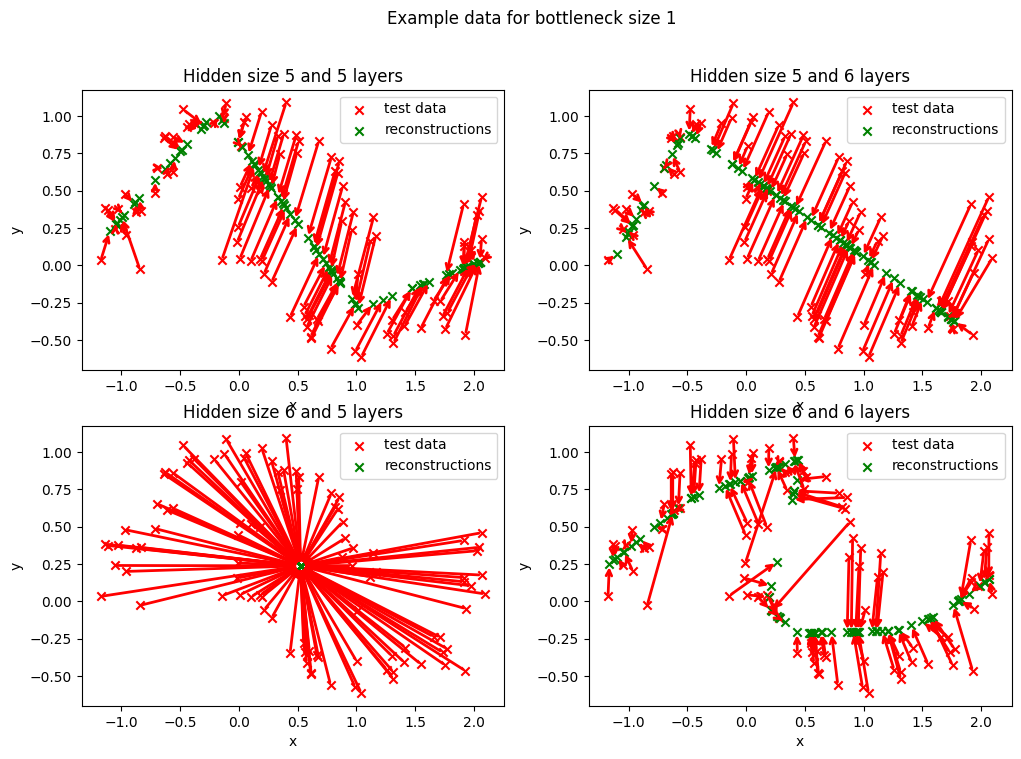

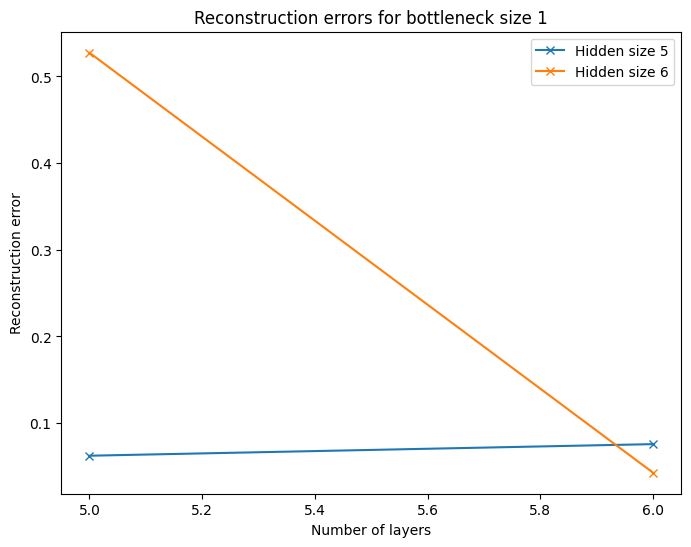

In [57]:
train_data = torch.from_numpy(datasets.make_moons(n_samples = n_train, noise = 0.1)[0]).float()
test_data = torch.from_numpy(datasets.make_moons(n_samples = n_test, noise = 0.1)[0]).float()

evaluate_space(train_data, test_data, n_epoch, loss_fn = MSE, lr = lr)

Excepting the case of 5 layers and hidden size 6, the networks are able to at least understand a (very) rough trend in the data. The network's reconstructions are closest to the input data for the model with the highest complexity. The very poor performance of the network with 5 layers and hidden size 6 is likely a training issue and not a fundamental problem with the network. Using more sophisticated weight initialization, different learning rates, and other approaches for training improvement woudl surely resolve this issue. 

_Evaluate specific HP configurations for different training sets_

C:\Users\Jonathan Bollig\AppData\Local\Temp\ipykernel_17512\366134822.py:106: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Jonathan Bollig\AppData\Local\Temp\ipykernel_17512\366134822.py:115: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  error_fig.show()


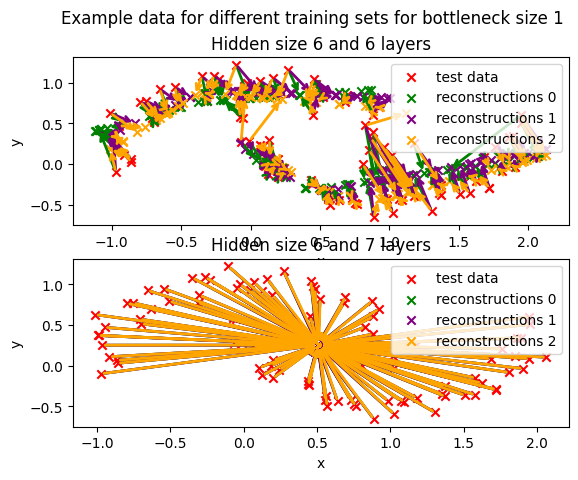

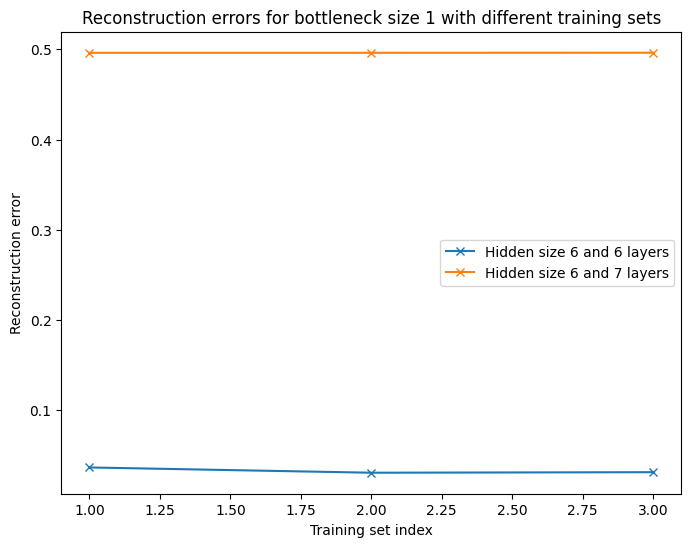

In [59]:
train_data_full = torch.from_numpy(datasets.make_moons(n_samples = 2*n_train, noise = 0.1)[0]).float()
train_data = [train_data_full[:n_train], train_data_full[:n_train], train_data_full[n_train:]]
test_data = torch.from_numpy(datasets.make_moons(n_samples = n_test, noise = 0.1)[0]).float()

evaluate_selection([(6, 6), (6, 7)], train_data, test_data, n_epoch, loss_fn = MSE, lr = lr)

We need to strictly seperate the two hyperparameter configurations considered in this task. The configuration (6, 6) showed overall good results. One can clearly see a deviation between the reconstructions from the first and second network that were trained on the same data. This is due to different weight initializations and data shuffling, leading to a different training process. Clearly though, the error is largest for the thirs training which we conducted on a different training set. This increase in error is likely a result of our poor choice of test set. Only after running the experiments did we realize that make_moons does not return randomly shuffles datapoints but always the same, such that our test set was actually the same as the training set throughout our experiments. This is a significant issue and changing this would lead to more meaningful results. The configuration (6, 7) on the other hand is problematic. Similar to the situation above we observe almost no training effect. This may again be an issue with our training and adding more training data, training for longer, and adjusting hyperparameters would likely fix this problem. 

_Construct Histogram_

Early stopping after 166 epochs


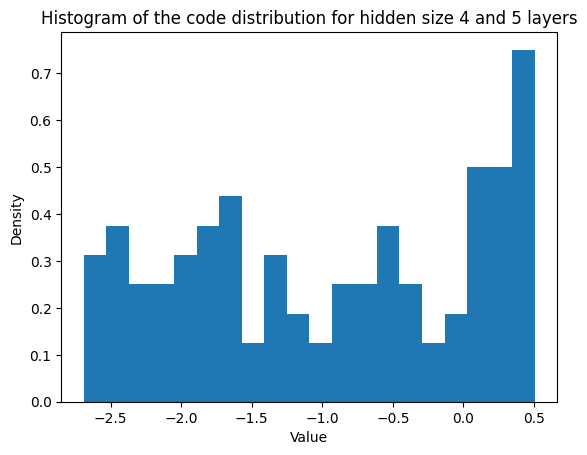

In [46]:
train_data = torch.from_numpy(datasets.make_moons(n_samples = n_train, noise = 0.1)[0]).float()
test_data = torch.from_numpy(datasets.make_moons(n_samples = n_test, noise = 0.1)[0]).float()

histogram(train_data, test_data, hidden_size = 4, layers = 5, n_epoch = n_epoch, loss_fn = MSE, lr = lr, bins = 20)

_Fit GMM to Code and Sample_

Code samples: [[ -2.59066992]
 [ -3.45419986]
 [ -5.58568185]
 [ -4.3885945 ]
 [ -4.09914663]
 [ -1.87440627]
 [ -5.90268527]
 [ -0.83581383]
 [ -2.50648386]
 [ -3.75962969]
 [  0.90219047]
 [ -5.13518502]
 [ -6.3654516 ]
 [ -5.61964284]
 [ -1.68029234]
 [ -3.56306325]
 [ -4.54899876]
 [ -4.26193339]
 [ -1.2282428 ]
 [ -3.36803672]
 [  0.28599777]
 [ -3.58479319]
 [ -3.71921446]
 [ -4.72973338]
 [ -3.72546607]
 [ -5.24777635]
 [ -4.71261589]
 [  1.96696901]
 [ -4.24462951]
 [  2.15404289]
 [ -0.38858069]
 [ -3.14409796]
 [ -4.8030734 ]
 [ -3.21489132]
 [ -4.190408  ]
 [ -1.50873117]
 [ -1.69806968]
 [ -4.81595774]
 [ -4.35154004]
 [ -5.17413909]
 [  1.29759076]
 [ -3.57743494]
 [ -2.67131807]
 [ -7.19626423]
 [ -4.7166903 ]
 [ -3.91628978]
 [ -3.8508785 ]
 [ -5.89364824]
 [ -4.81605599]
 [ -5.10406686]
 [ -4.22609881]
 [ -2.95232356]
 [ -1.92166467]
 [ -1.97806595]
 [ -1.19337642]
 [-10.26522617]
 [-11.75375926]
 [-10.79999704]
 [ -9.74179049]
 [ -9.96482803]
 [-10.50815309]
 [-10.3552

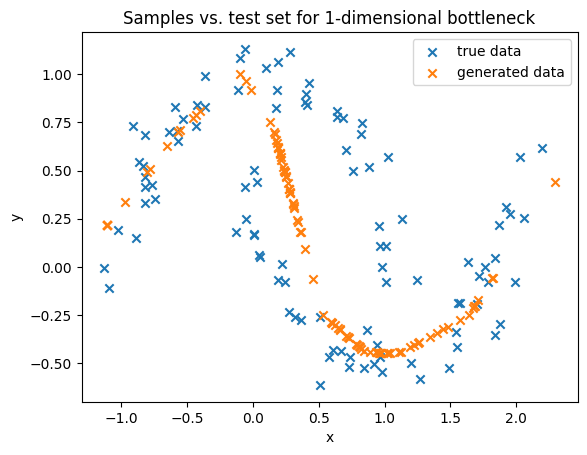

array([[ -2.59066992],
       [ -3.45419986],
       [ -5.58568185],
       [ -4.3885945 ],
       [ -4.09914663],
       [ -1.87440627],
       [ -5.90268527],
       [ -0.83581383],
       [ -2.50648386],
       [ -3.75962969],
       [  0.90219047],
       [ -5.13518502],
       [ -6.3654516 ],
       [ -5.61964284],
       [ -1.68029234],
       [ -3.56306325],
       [ -4.54899876],
       [ -4.26193339],
       [ -1.2282428 ],
       [ -3.36803672],
       [  0.28599777],
       [ -3.58479319],
       [ -3.71921446],
       [ -4.72973338],
       [ -3.72546607],
       [ -5.24777635],
       [ -4.71261589],
       [  1.96696901],
       [ -4.24462951],
       [  2.15404289],
       [ -0.38858069],
       [ -3.14409796],
       [ -4.8030734 ],
       [ -3.21489132],
       [ -4.190408  ],
       [ -1.50873117],
       [ -1.69806968],
       [ -4.81595774],
       [ -4.35154004],
       [ -5.17413909],
       [  1.29759076],
       [ -3.57743494],
       [ -2.67131807],
       [ -7

In [61]:
train_data = torch.from_numpy(datasets.make_moons(n_samples = n_train, noise = 0.1)[0]).float()
test_data = torch.from_numpy(datasets.make_moons(n_samples = n_test, noise = 0.1)[0]).float()

fit_GMM_to_code(
    train_data, 
    test_data, 
    hidden_size = 6, 
    layers = 6, 
    n_epoch = n_epoch, 
    loss_fn = MSE, 
    lr = lr, 
    mmd_loss = False, 
    N = 100, 
    bottleneck_size = 1, 
    gmm_components = 2, 
    gmm_steps = 10)

The generated data is rather close to the reconstructions made by the network in the previous task. This means that while the networks did not learn the distribution very well, the sampling process works as it should and returns items expected from the code distribution.

_Testing at Noise Level 0.2_

C:\Users\Jonathan Bollig\AppData\Local\Temp\ipykernel_17512\2953826684.py:106: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Jonathan Bollig\AppData\Local\Temp\ipykernel_17512\2953826684.py:115: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  error_fig.show()


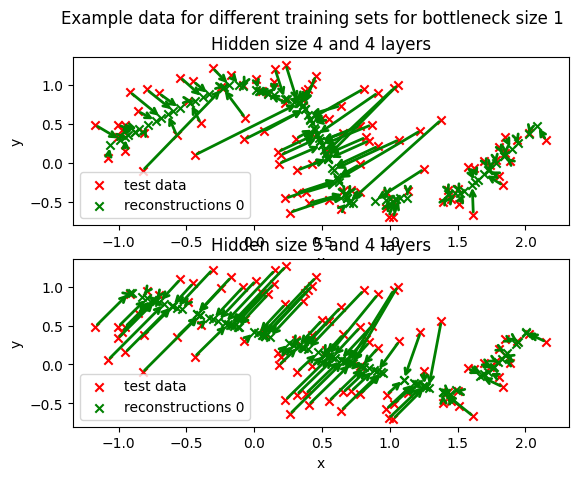

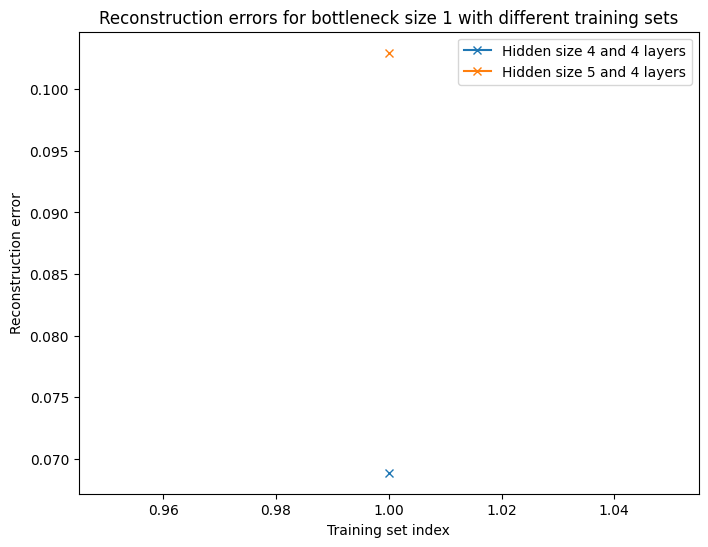

In [63]:
train_data = [torch.from_numpy(datasets.make_moons(n_samples = n_train, noise = 0.1)[0]).float()]
test_data = torch.from_numpy(datasets.make_moons(n_samples = n_test, noise = 0.2)[0]).float()

evaluate_selection([(4, 4), (5, 4)], train_data, test_data, n_epoch, loss_fn = MSE, lr = lr)

Surprisingly, the reconstructions of more noisy data at least in the case of the hyperparameter configuration (4, 4) actually lead to a better representation of the underlying data distribution. This may be attributed to the fact that with more noisy input data, the network explores a larger part of the code distribution, therefore performing a better interpolation between the training data points (which in our case are the same as the test data points).

_Training and Testing at Noise Level 0.2_

C:\Users\Jonathan Bollig\AppData\Local\Temp\ipykernel_17512\2953826684.py:106: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Jonathan Bollig\AppData\Local\Temp\ipykernel_17512\2953826684.py:115: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  error_fig.show()


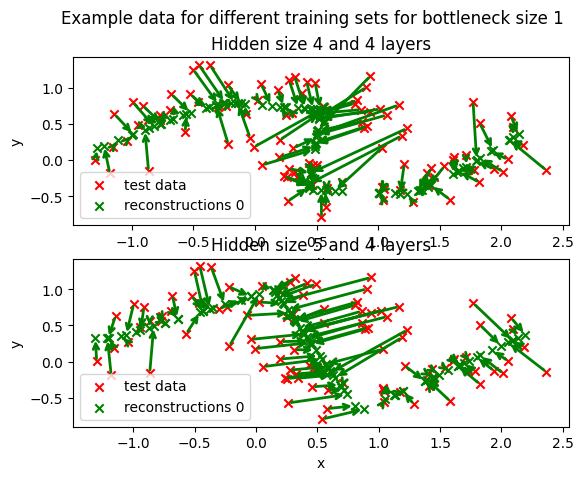

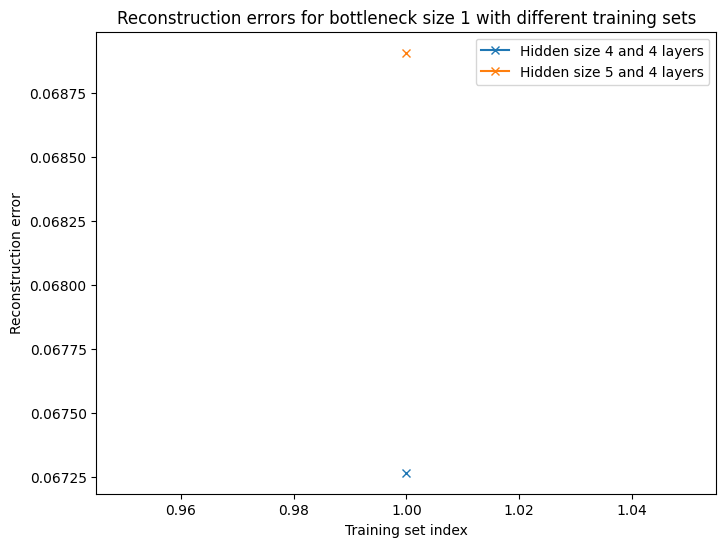

In [64]:
train_data = [torch.from_numpy(datasets.make_moons(n_samples = n_train, noise = 0.2)[0]).float()]
test_data = torch.from_numpy(datasets.make_moons(n_samples = n_test, noise = 0.2)[0]).float()

evaluate_selection([(4, 4), (5, 4)], train_data, test_data, n_epoch, loss_fn = MSE, lr = lr)

As above, we notice that the networks consistently perform as well as the best networks trained at lower noise. Again, this may be attributed to the fact that the networks learn only a very rough representation of the data in the latent space, but through the increased noise are forced to explore a larger part of the latent distribution, leading to a smoother interpolation, which is really the main advantage seen in these results. Numerically, the differences are not very significant.

_Bottleneck Size 2_

Running evaluation for hidden size 4 and 2 layers.
Early stopping after 52 epochs
Running evaluation for hidden size 4 and 3 layers.
Early stopping after 27 epochs
Running evaluation for hidden size 5 and 2 layers.
Early stopping after 38 epochs
Running evaluation for hidden size 5 and 3 layers.
Early stopping after 27 epochs


C:\Users\Jonathan Bollig\AppData\Local\Temp\ipykernel_17512\3471494640.py:39: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Jonathan Bollig\AppData\Local\Temp\ipykernel_17512\3471494640.py:48: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  error_fig.show()


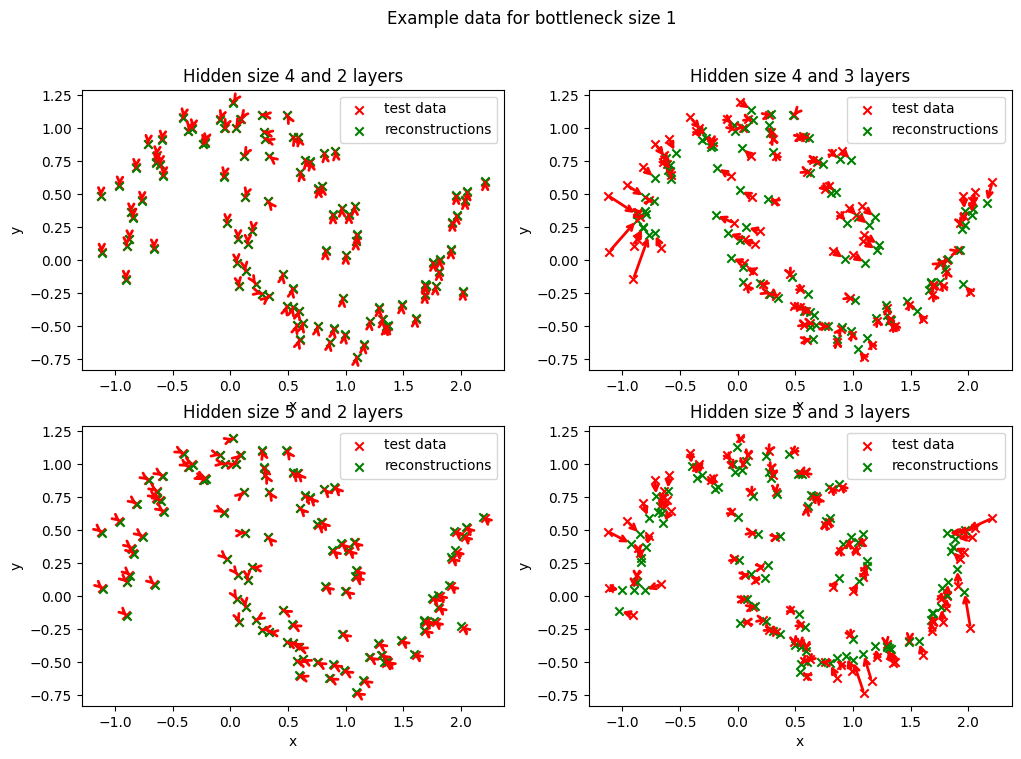

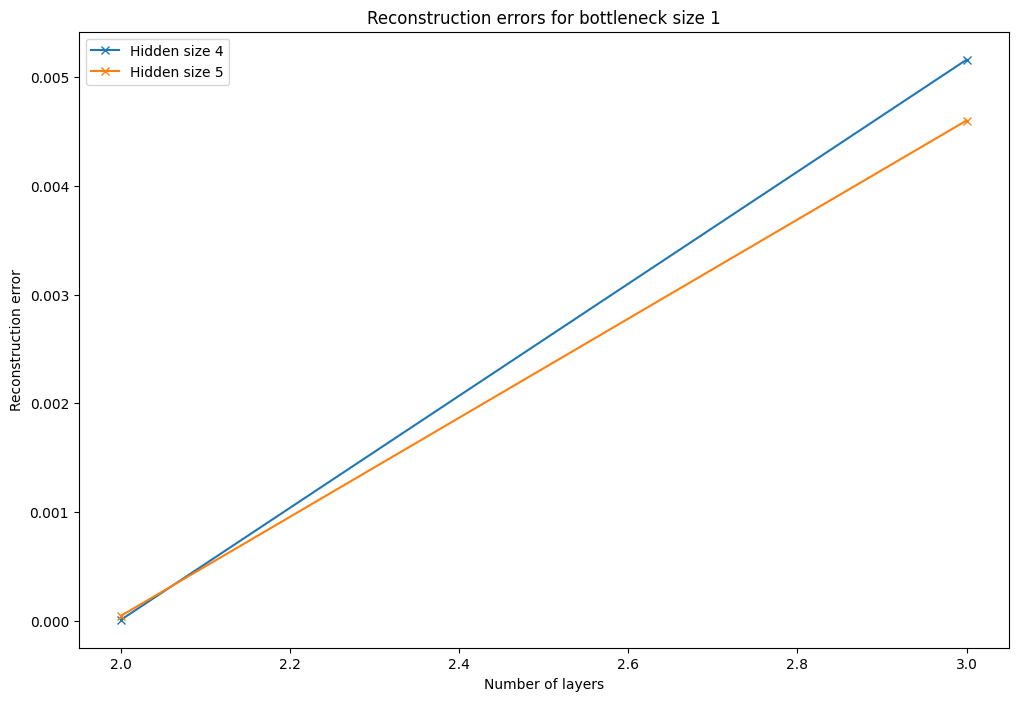

In [ ]:
loss_fn = partial(mmd2_mse_loss, bandwidth_start = 0.5, num_bandwidths = 5, mmd_weight = 1)
train_data = torch.from_numpy(datasets.make_moons(n_samples = n_train, noise = 0.1)[0]).float()
test_data = torch.from_numpy(datasets.make_moons(n_samples = n_test, noise = 0.1)[0]).float()

evaluate_space(train_data, test_data, n_epoch = n_epoch, loss_fn = loss_fn, lr = lr, bottleneck_size = 2, mmd_loss = True)

As expected, we have numerically and qualitatively better results when using the 2D bottleneck as compared to the 1D bottleneck. This is to expected, as not loss of information is enforced by the network architecture from the very beginning, as very nicely shown with our results.

_Generating data for Bottleneck Size 2_

Unfortunately, training the higher-dimensional models with a reasonable number of layers and appropriate values for the layers took a very long time. The code itself is functional and we invite anyone with CUDA support to run the training on their machines. As a result of this we were not able to finish all experiments in time.

In [ ]:
loss_fn = partial(mmd2_mse_loss, bandwidth_start = 0.5, num_bandwidths = 5, mmd_weight = 1)
train_data = torch.from_numpy(datasets.make_moons(n_samples = n_train, noise = 0.1)[0]).float()
test_data = torch.from_numpy(datasets.make_moons(n_samples = n_test, noise = 0.1)[0]).float()

AE = AutoEncoder(2, bottleneck_size = 2, hidden_size = 4, layers = 4)
train_model(AE, n_epoch, loss_fn, train_data, lr, mmd_loss = True)

In [ ]:
sample_with_normal(n_test, test_data, AE, train_data, n_epoch, loss_fn, lr, bottleneck_size = 2, mmd_loss = True, hidden_size=4, layers=4)

_Higher-dimensional data_

In [ ]:
train_data = load_digits()['data'][:n_train]
train_labels = load_digits()['target'][:n_train]
test_data = load_digits()['data'][n_train:n_train+n_test]
test_labels = load_digits()['target'][n_train:n_train+n_test]
bottleneck_sizes = [2, 4, 8]
for bottleneck_size in bottleneck_sizes:
    evaluate_space(train_data, test_data, n_epoch, loss_fn = MSE, hidden_size_space=[128], layer_space=[4], input_size = 64, bottleneck_size = bottleneck_size)

In [ ]:
forest = train_RFC(train_data, train_labels)

In [ ]:
for bottleneck_size in bottleneck_sizes:
    AE = AutoEncoder(64, bottleneck_size, 128, 2)
    train_model(AE, n_epoch, MSE, train_data, lr)
    AE.eval()
    recos = AE.forward(test_data)
    test_predictions, reco_predictions = evaluate_digit_samples(forest, test_data, recos)
    accuracy = 1-(np.count_nonzero(test_predictions-reco_predictions)/test_predictions.shape[0])
    print(f"Accuracy for bottleneck size {bottleneck_size}: {accuracy}")

In [ ]:
for bottleneck_size in bottleneck_sizes:
    samples = fit_GMM_to_code(train_data, test_data, 128, 2, n_epoch, MSE, lr, False, 100, bottleneck_size, 4, 3, 64)
    _, sample_predictions = evaluate_digit_samples(forest, test_data, samples)
    fig, axs = plt.subplots(1, 8)
    for i, ax in enumerate(axs[0]):
        ax.imshow(samples[i], cmap = "gray")
        ax.set_title(f"Prediction: {sample_predictions[i]}")